In [1]:
#So I need to find a library that can reliably generate synth data

#can use Numpy - However this is doing it manually which isnt something that is needed 


In [2]:

import numpy as np
import sdgym
import pandas as pd
import sdv
from sklearn.metrics import f1_score
from sdv.metrics.tabular import CSTest, KSTest
import math


In [351]:
#Methods to vectorise and replace emtpy entries

def vectorise(df):
    new_data = {}
    empty = '?'
    for(name,data) in df.iteritems():

        if type(data[0]) == str:
            uni = (data.str.split(';\s*', expand=True).stack().unique())
            reformed = []
            for i in data:
                if i == empty:
                    reformed.append('')
                else:
                    reformed.append(list(uni).index(i))

            new_data[name] = reformed
        else:
            new_data[name] = data

    new_test = pd.DataFrame(new_data)
    return(new_test)

def fill(df):
    new_data = {}
    for(name,data) in df.iteritems():
        x = data.to_numpy()
  
        index = 0
        total = 0
        length = 0
        
        for i in x.tolist():
            if type(i) is int or float:
                if not i == '': 
                    if math.isnan(i):
                        x[index] = 0
                    total += x[index]
                length +=1
            if type(i) != str:    
                if math.isnan(i):
                    x[index] = 0
            index +=1  
        
        average = round(total/length)
        
        x = np.where(x == '', average, x)
        
        new_data[name] = x
        
    return(pd.DataFrame(new_data))

In [394]:
#ds = pd.read_csv('/Users/alextaylor/Desktop/heart.csv')

#read in DS
ds = pd.read_csv('/Users/alextaylor/Desktop/Pro_DS/Reg/adult.csv')

#Vectorise words and then fill in gaps 
ds = fill(vectorise(ds))

gender = 'gen'
g_male = 0
g_female = 1

print(len(ds))

ds_m = ds[ds[gender] ==g_male]
ds_w = ds[ds[gender] ==g_female]

print(len(ds_m))
print(len(ds_w))


<ipython-input-351-9746c4b73186>:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  x = np.where(x == '', average, x)


32561
21790
10771


In [380]:
# Now generate synth data from this list 

#ds_w = women only -
#ds_m = men only   - All have the same amount of data
#gb_data = mixed   -
 
    
from sdv.tabular import GaussianCopula as gaussCop
from sdv.tabular import CopulaGAN
from sdv.constraints.tabular import Positive
from sdv.constraints import GreaterThan

def neg_check(data_set):
        
    for (name,data) in gb_data.iteritems():
        for i in data:
            if i < 0:
                return name

non_neg_peak = Positive(
        high='oldpeak',
        strict= False,
        handling_strategy='reject_sampling'
    )
non_neg_cp = Positive(
        high='cp',
        strict= False,
        handling_strategy='reject_sampling'
    )
non_neg_slope = Positive(
        high='slope',
        strict= False,
        handling_strategy='reject_sampling'
    )
non_neg_fbs = Positive(
        high='fbs',
        strict= False,
        handling_strategy='reject_sampling'
    )
non_neg_ca = Positive(
        high='ca',
        strict= False,
        handling_strategy='reject_sampling'
    )
non_neg_thal = Positive(
        high='thal',
        strict= False,
        handling_strategy='reject_sampling'
    )
non_neg_restecg = Positive(
        high='restecg',
        strict= False,
        handling_strategy='reject_sampling'
    )

cons = [non_neg_peak,non_neg_cp,non_neg_fbs,non_neg_slope,non_neg_thal,non_neg_ca,non_neg_restecg]

field_distributions = {
    'capital-gain': 'gamma',
    'capital-loss': 'gamma'
}

#commented out cons for some final tests 
syn_model = CopulaGAN(field_distributions=field_distributions)#, constraints=cons)

#Need the same amount of data so take the total and div by two, 
total_needed = int(len(ds)/2)

print(total_needed)
print(len(ds_w))

if len(ds_w) < total_needed:
    #male dominated
    gb_data = ds_m[0:total_needed]
    print('male dominated - Fitting for female data')
    syn_model.fit(ds_w)
    
    print('female data fitted now generating for GB and fem data sets')
    print(total_needed)
    print(len(ds_w))
    gb_data = gb_data.append(ds_w.append(syn_model.sample(total_needed - len(ds_w))))
    
    #Need the all female ds to be equal size of the total data
    diff = len(ds) - len(ds_w)
    
    ds_w = ds_w.append(syn_model.sample(diff))
    #Need the all male ds to be equal to the size of the total data
    
    print('fitting male data')
    syn_model.fit(ds_m)
    diff = len(ds) - len(ds_m)

    ds_m = ds_m.append(syn_model.sample(diff))
    
    
else:
    
    print('female dominated - fitting for male data')
    gb_data = ds_w[0:total_needed]
    #Female dominated test set
    syn_model.fit(ds_m)
    gb_data = gb_data.append(ds_m.append(syn_model.sample(total_needed - len(ds_m))))
    
    #Need the all female ds to be equal size of the total data
    diff = len(ds) - len(ds_m)
    
    ds_m = ds_m.append(syn_model.sample(diff))
    #Need the all male ds to be equal to the size of the total data
    print('fitting for male data')
    syn_model.fit(ds_w)
    diff = len(ds) - len(ds_w)

    ds_w = ds_w.append(syn_model.sample(diff))
    
#Need the all female ds to be equal size of the total data    
print(len(ds_w))
print(len(ds_m))

print(CSTest.compute(ds, gb_data))

#Next run try to keep the origonal data

if(len(gb_data[gb_data[gender] ==g_male]) == len(gb_data[gb_data[gender] ==g_female]) ):
    print('dataset has been gender balanced')
else:
    print('data not gender balanced')
    print(len(gb_data[gb_data[gender] ==g_male]))
    print(len(gb_data[gb_data[gender] ==g_female]))


2021-08-23 16:23:44,535 : MainThread : INFO : Fitting table None metadata
2021-08-23 16:23:44,543 : MainThread : INFO : Anonymizing table None
2021-08-23 16:23:44,545 : MainThread : INFO : Fitting constraints for table None
2021-08-23 16:23:44,546 : MainThread : INFO : Fitting HyperTransformer for table None


147
81
male dominated - Fitting for female data


/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4963: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as p

female data fitted now generating for GB and fem data sets
147
81


2021-08-23 16:24:57,845 : MainThread : INFO : Fitting table None metadata
2021-08-23 16:24:57,850 : MainThread : INFO : Anonymizing table None
2021-08-23 16:24:57,852 : MainThread : INFO : Fitting constraints for table None
2021-08-23 16:24:57,854 : MainThread : INFO : Fitting HyperTransformer for table None


fitting male data


/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4963: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alextaylor/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as p

294
294
0.9737927985645002
dataset has been gender balanced


In [269]:
for (name,data) in gb_data.iteritems():
        for i in data:
            if i < 0:
                print(name)

PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_

PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_0
PAY_

PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_

PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_2
PAY_

PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_

PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_3
PAY_

PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_4
PAY_

PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_

PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_5
PAY_

PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_6
PAY_

BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1
BILL_AMT1


In [381]:
from sklearn.model_selection import train_test_split

target = '12'

gb_target = gb_data[target].to_numpy()
gb_data = gb_data.drop(target,axis = 1)

old_tar = ds[target].to_numpy()
ds= ds.drop(target,axis = 1)

w_target = ds_w[target].to_numpy()
ds_w= ds_w.drop(target,axis = 1)

m_target = ds_m[target].to_numpy()
ds_m = ds_m.drop(target,axis = 1)

gb_xtrain,gb_xtest,gb_ytrain,gb_ytest = train_test_split(gb_data,gb_target,shuffle = True)
nb_xtrain,nb_xtest,nb_ytrain,nb_ytest = train_test_split(ds,old_tar,shuffle = True)
w_xtrain,w_xtest,w_ytrain,w_ytest = train_test_split(ds_w,w_target,shuffle = True)
m_xtrain,m_xtest,m_ytrain,m_ytest = train_test_split(ds_m,m_target,shuffle = True)

nan

In [382]:
#So spliting geneder from the ds, but will still need it to reference later

models_gen = [[gb_xtrain,gb_ytrain],[nb_xtrain,nb_ytrain],[w_xtrain,w_ytrain],[m_xtrain,m_ytrain]]
gb_xtrain = pd.DataFrame(gb_xtrain).drop(gender,axis = 1).to_numpy()
nb_xtrain = pd.DataFrame(nb_xtrain).drop(gender,axis = 1).to_numpy()
w_xtrain = pd.DataFrame(w_xtrain).drop(gender,axis = 1).to_numpy()
m_xtrain = pd.DataFrame(m_xtrain).drop(gender,axis = 1).to_numpy()

models = [[gb_xtrain,gb_ytrain],[nb_xtrain,nb_ytrain],[w_xtrain,w_ytrain],[m_xtrain,m_ytrain]]
tests_gen = [[nb_xtest,nb_ytest],[w_xtest,w_ytest],[m_xtest,m_ytest],[gb_xtest,gb_ytest]]

gb_xtest = pd.DataFrame(gb_xtest).drop(gender,axis = 1).to_numpy()
nb_xtest = pd.DataFrame(nb_xtest).drop(gender,axis = 1).to_numpy()
w_xtest = pd.DataFrame(w_xtest).drop(gender,axis = 1).to_numpy()
m_xtest = pd.DataFrame(m_xtest).drop(gender,axis = 1).to_numpy()

tests = [[nb_xtest,nb_ytest],[w_xtest,w_ytest],[m_xtest,m_ytest],[gb_xtest,gb_ytest]]

#Use these list to loop over once created 


In [377]:
from sklearn.metrics import f1_score

def percent_total(results,answers,training,gens):
    index = 0
    correct = 0
    incorrect =0
    total = 0
    c_male = 0
    c_female = 0
    male = 0
    female = 0
    #target = target.to_numpy()
    #compare aginst the actual results]
    
    print('Here')
    for i in results:
        total += 1
        if answers[index] == i:
            correct += 1
            if gens[index] == g_male:
                c_male +=1
                male+=1
            elif gens[index] == g_female:
                c_female +=1
                female +=1
        else:
            if gens[index] == g_male:
                male +=1
            elif gens[index] == g_female:
                female +=1
        index += 1
    print('correct male : female')  
    if male == 0:
        print("No male test cases :",(c_female/female*100),'%') 
        print(round((correct/total)*100,2),',',round(f1_score(answers, results, average='macro'),2),',','na',',',round(c_female/female*100,2))
        
    elif female == 0:
        print((c_male/male)*100 ,"% : No female test cases") 
        print(round((correct/total)*100,2),',',round(f1_score(answers, results, average='macro'),2),',',round((c_male/male)*100,2),',','na')
    else:
        print((c_male/male)*100 ,"% :",(c_female/female*100),'%')    
        print(round((correct/total)*100,2), ',', round(f1_score(answers, results, average='macro'),2),',',round((c_male/male)*100,2),',',round((c_female/female*100),2))

    

In [242]:
print((tests_gen[1][0]))

        1   2       3  4   5  6   7  8  9  gen     10    11  12  13
8131   78   1  983075  0   6  4   4  2  0    1   4643    -5  40   0
27658  19   2  157605  1   9  2   4  0  0    1      0     0  40   0
10914  25   2  202088  3   9  4   5  2  5    1    -88   -11  71   0
12102  17   3  183677  1  11  6   3  0  0    1     63     7  24   0
20696  36   2   38452  1   9  0   3  5  2    1  15666  1922  54   1
...    ..  ..     ... ..  .. ..  .. .. ..  ...    ...   ...  ..  ..
25390  20   2  275357  7  11  0  10  3  0    1      0     0  25   0
18869  19   5  268356  1   7  2   4  2  2    1    700   -11  41   0
9258   45 -71  217723  0   7  1   1  4  0    1   2624  2307  21   0
5354   22   2  617113  1   9  2   8  3  1    1    -87   -11  25   0
8107   17   2  119765  5   6  0   4  6  1    1  21091  2303  21   0

[8141 rows x 14 columns]


0
gen
0
<class 'list'>


average:  49.544061001493596


GB model
neutal test
Here
correct male : female
83.33333333333334 % : 100.0 %
87.84 , 0.87 , 83.33 , 100.0

female test
Here
correct male : female
No male test cases : 86.48648648648648 %
86.49 , 0.61 , na , 86.49

male test
Here
correct male : female
78.37837837837837 % : No female test cases
78.38 , 0.75 , 78.38 , na

GB test
Here
correct male : female
92.6829268292683 % : 84.84848484848484 %
89.19 , 0.79 , 92.68 , 84.85

--------------
Neutral model
neutal test
Here
correct male : female
74.07407407407408 % : 85.0 %
77.03 , 0.75 , 74.07 , 85.0

female test
Here
correct male : female
No male test cases : 74.32432432432432 %
74.32 , 0.51 , na , 74.32

male test
Here
correct male : female
77.02702702702703 % : No female test cases
77.03 , 0.75 , 77.03 , na

GB test
Here
correct male : female
97.5609756097561 % : 81.81818181818183 %
90.54 , 0.83 , 97.56 , 81.82

--------------
female model
neutal test
Here
correct male : female
68.51851851851852 % : 90.0 %
74.32 , 0.48 , 68.52 , 90.0

f

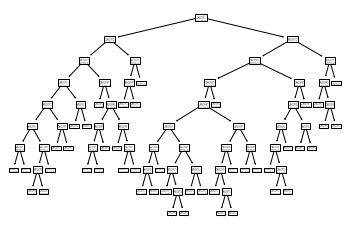

In [386]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
def tree(x_train,y_train,x_test,y_test,y_gen):
    
    #the results were always gini and best so going to stick with them 
    cri = ['gini'] #, 'entropy']
    splitter = ['best']#'random']
    best = 0

    for i in cri:
        for k in splitter:
            clf = DecisionTreeClassifier(criterion = i,splitter = k)
            clf = clf.fit(x_train,y_train)
            res = clf.predict(x_test)
            percent = percent_total(res,y_test,x_test,y_gen)

            if best == 0:
                best = [percent,i,k]
            elif percent > best[0]:
                best = [percent,i,k]
            
            plot_tree(clf)
            return best

index =0
test_index = 0
gender_index = 0

for i in models:
    #loop over all the models then one set of tests for each model 
    if index == 0:
        print("GB model")
    elif index == 1:
        print('Neutral model')
    elif index == 2:
        print('female model')
    else:
        print('male model')
    for k in tests:
        if test_index == 0:
            print('neutal test')
            gender_index = 0
        elif test_index == 1:
            print('female test')
            gender_index = 1
        elif test_index ==2:
            print('male test')
            gender_index = 2
        else:
            print('GB test')
            gender_index = 3
        #run tree -xtrain,ytrain,x_test,y_test
        tree(i[0],i[1],k[0],k[1],pd.DataFrame(tests_gen[gender_index][0])[gender].to_numpy())
        test_index +=1
        print('')
    print("--------------")
    index +=1
    test_index = 0

Here
correct male : female
92.6829268292683 % : 87.87878787878788 %
90.54 , 0.81 , 92.68 , 87.88


[None, 'gini', 'best']

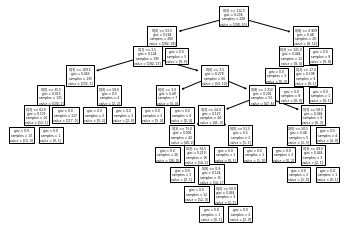

In [391]:
gb = models[1]
gb_test = tests[0]

tree(gb[0],gb[1],gb_test[0],gb_test[1],pd.DataFrame(tests_gen[3][0])[gender].to_numpy())

Here
correct male : female
92.6829268292683 % : 81.81818181818183 %
87.84 , 0.77 , 92.68 , 81.82


[None, 'gini', 'best']

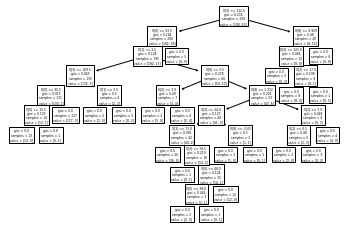

In [392]:
gb = models[0]
gb_test = tests[3]

tree(gb[0],gb[1],gb_test[0],gb_test[1],pd.DataFrame(tests_gen[3][0])[gender].to_numpy())